# Synthetic DIGITAL TWIN OF A GROUNDWATER EXAMPLE

Corresdong to Chapter 5 of the course "Introduction to digital twin" by Romain CHASSAGNE - https://rlchassagne.github.io/

Webapp example : https://digital-twin-groundwater-4aephvxm7sz3kgvcpfo9o8.streamlit.app/

File exported with 100 points and wave spacing of 5.


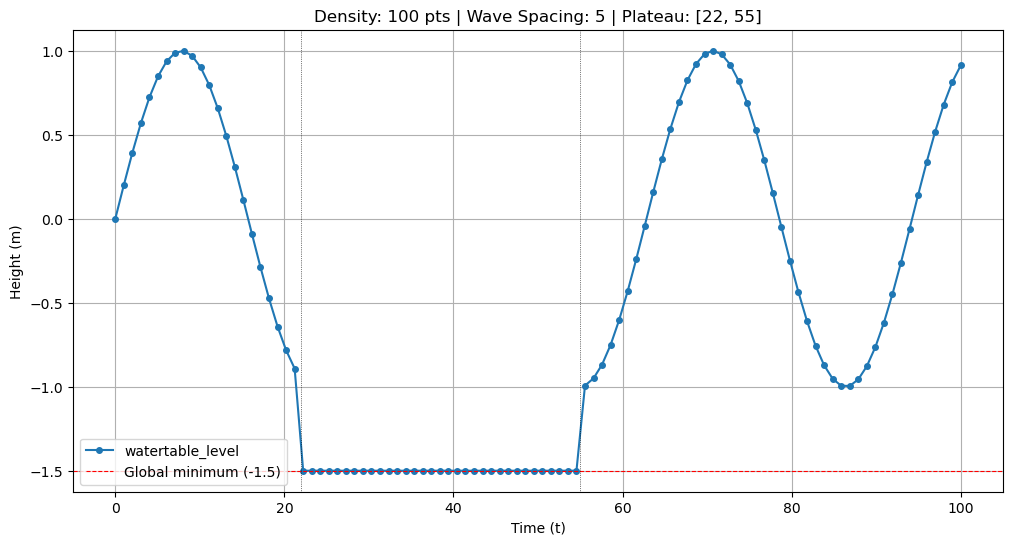

In [1]:
#============================The physical state or real-world ====================================================================
#-------------------------------------------------------------------------------------------------------------------

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# 1. PARAMETERS
NUM_POINTS = 100        # <--- sampling points
WAVE_SPACING = 5        
T_PLATEAU_START = 22
T_PLATEAU_END = 55
PLATEAU_VALUE = -1.5

# Data generation
Time = np.linspace(0, 100, NUM_POINTS)

# Modification : on divise Time par WAVE_SPACING pour étirer la sinusoïde
Initial_Height = np.sin(Time / WAVE_SPACING) 

# Initialize modified height
Modified_height = Initial_Height.copy()

# 2. CREATE INTERVAL MASK
PLATEAU_MASK = (Time >= T_PLATEAU_START) & (Time <= T_PLATEAU_END)

# 3. APPLY MODIFICATION
Modified_height[PLATEAU_MASK] = PLATEAU_VALUE

# 4. CREATE DATAFRAME AND CSV EXPORT
df_modified = pd.DataFrame({
    "Height": Modified_height, 
    "Time": Time 
})

# Export CSV
df_modified.to_csv("groundwater_level_modified.csv", index=False)
print(f"File exported with {NUM_POINTS} points and wave spacing of {WAVE_SPACING}.")

# 5. PLOT
plt.figure(figsize=(12, 6))
# Utilisation de marker='o' pour bien voir les points individuels
plt.plot(df_modified["Time"], df_modified["Height"], 
         marker='o', markersize=4, label="watertable_level")

plt.axhline(PLATEAU_VALUE, color='r', linestyle='--', linewidth=0.8, 
            label=f"Global minimum ({PLATEAU_VALUE})")
plt.axvline(T_PLATEAU_START, color='k', linestyle=':', linewidth=0.5)
plt.axvline(T_PLATEAU_END, color='k', linestyle=':', linewidth=0.5)

plt.xlabel("Time (t)")
plt.ylabel("Height (m)")
plt.title(f"Density: {NUM_POINTS} pts | Wave Spacing: {WAVE_SPACING} | Plateau: [{T_PLATEAU_START}, {T_PLATEAU_END}]")
plt.grid(True)
plt.legend()
plt.show()

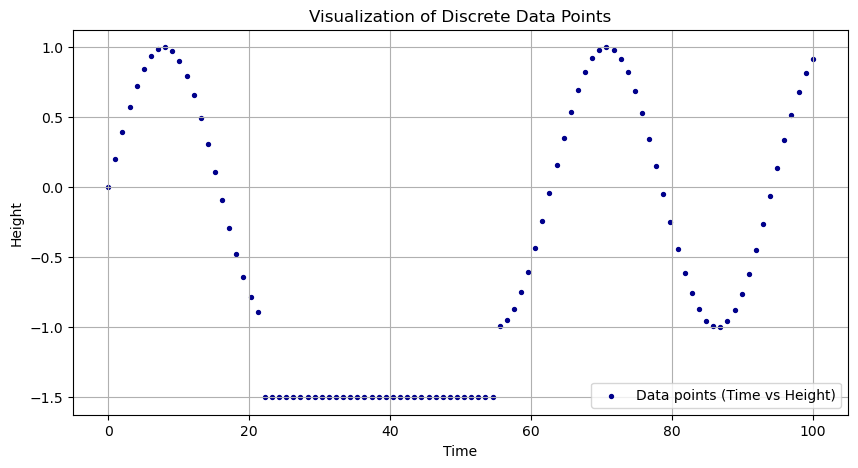

In [2]:
#=============== Data acquisition and assessment ===========================================================

import pandas as pd
import matplotlib.pyplot as plt

# 1. Name of the file to read
FILE_NAME = "groundwater_level_modified.csv"

# 2. Read the CSV file
try:
    df = pd.read_csv(FILE_NAME)
except FileNotFoundError:
    print(f"Error: The file '{FILE_NAME}' was not found. Make sure it is in the same directory.")
    exit()
except Exception as e:
    print(f"An error occurred while reading the file: {e}")
    exit()

# 3. Check for columns
if 'Time' not in df.columns or 'Height' not in df.columns:
    print("Error: 'Time' and 'Height' columns are required for plotting.")
    exit()

# 4. Plot points only
plt.figure(figsize=(10, 5))

# Using plt.scatter to display points without connecting lines.
plt.scatter(df["Time"], df["Height"], 
            label="Data points (Time vs Height)",
            color='darkblue',
            s=8) # 's' defines the size of each point.

# 5. Finalize the graph
plt.xlabel("Time")
plt.ylabel("Height")
plt.title("Visualization of Discrete Data Points")
plt.grid(True)
plt.legend()
plt.show()

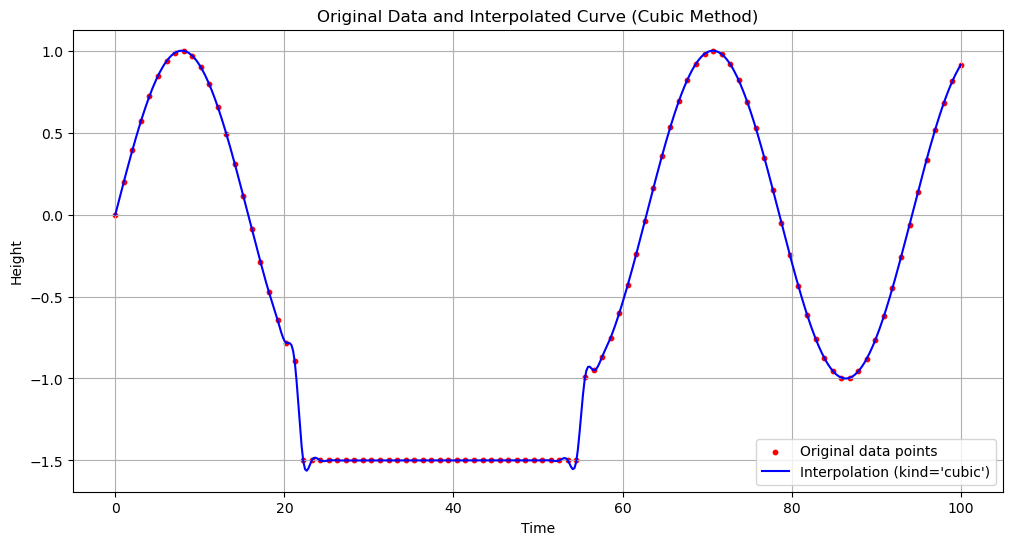

In [3]:
#======= Modelling (interpolation) ==========================================

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.interpolate import interp1d

# 1. Filename to read and parameters
FILE_NAME = "groundwater_level_modified.csv"
NUMBER_INTERPOLATED_POINTS = 500  # For a very smooth curve

# 2. Read the CSV file
try:
    df = pd.read_csv(FILE_NAME)
except FileNotFoundError:
    print(f"Error: The file '{FILE_NAME}' was not found. Make sure it is in the same directory.")
    exit()

# 3. Column verification and data extraction
if 'Time' not in df.columns or 'Height' not in df.columns:
    print("Error: 'Time' and 'Height' columns are required for interpolation.")
    exit()

x_original = df["Time"].values
y_original = df["Height"].values

# 4. Create the interpolation function
# We use cubic interpolation ('cubic') for very smooth results.
# You can also use 'linear' or 'quadratic'.
f_interpolation = interp1d(x_original, y_original, kind='cubic')

# 5. Generate new smooth time points
# We create many more points (x_new) to plot the smooth curve.
x_new = np.linspace(x_original.min(), x_original.max(), NUMBER_INTERPOLATED_POINTS)

# 6. Calculate new interpolated values
y_interpolated = f_interpolation(x_new)

# 7. Plot original and interpolated data
plt.figure(figsize=(12, 6))

# Plot original points (as discrete points)
plt.scatter(x_original, y_original, 
            label="Original data points",
            color='red', 
            s=10) # 's' is the point size

# Plot the interpolated curve (continuous line)
plt.plot(x_new, y_interpolated, 
         label=f"Interpolation (kind='cubic')",
         color='blue', 
         linewidth=1.5)

# 8. Finalize the graph
plt.xlabel("Time")
plt.ylabel("Height")
plt.title(f"Original Data and Interpolated Curve (Cubic Method)")
plt.legend()
plt.grid(True)
plt.show()

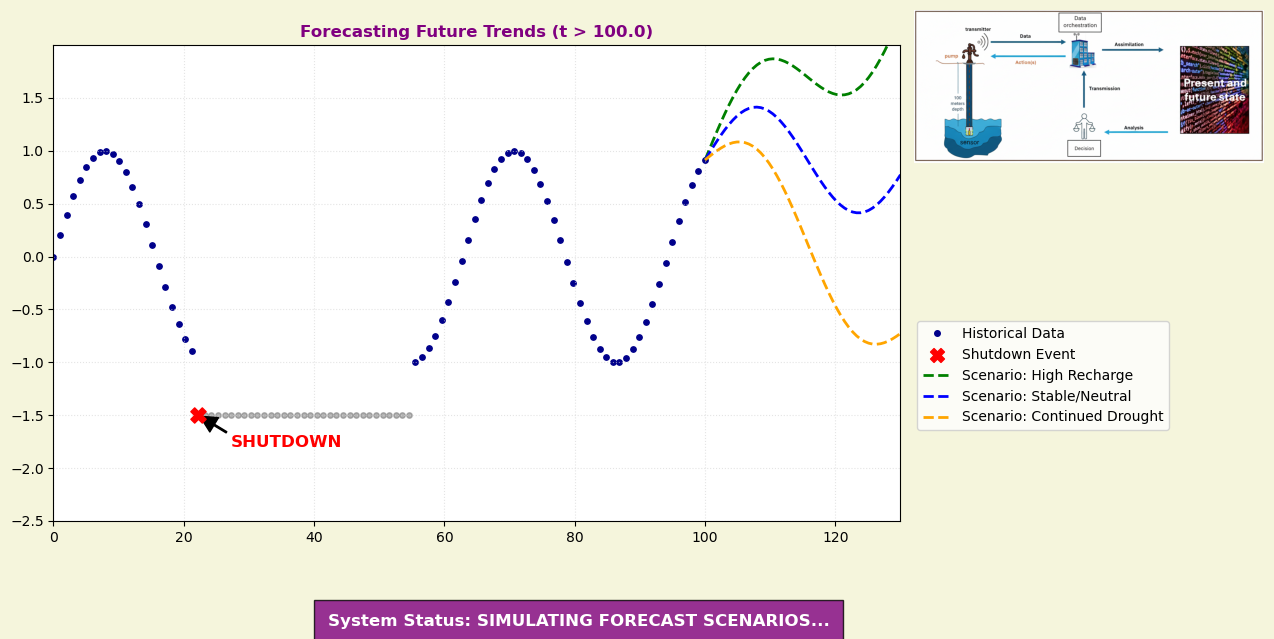

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import time

# 1. SETUP THE POPUP BACKEND
# %matplotlib qt  # Uncomment for local environment

# 2. Filename and parameters
FILE_NAME = "groundwater_level_modified.csv"
IMAGE_NAME = "DT.png" 
MINIMUM_THRESHOLD = -1.2
BROWN_COLOR = '#F5F5DC' 

STOP_MSG = "July 24 at 05:00 t=40 >>> Groundwater Level too low: PUMP STOPPED <<<"
RESTART_MSG = "August 20 at 22:00 t=50 >>> Groundwater Level safe: PUMP ON <<<"

# 3. Read the CSV file
try:
    df = pd.read_csv(FILE_NAME)
except FileNotFoundError:
    print(f"Error: The file '{FILE_NAME}' was not found.")
    exit()

stop_indices = df['Height'] <= MINIMUM_THRESHOLD
stop_index = stop_indices.idxmax() if stop_indices.any() else len(df)
stop_found = stop_indices.any()

# --- POPUP ANIMATION LOGIC ---

plt.ion() 
fig, ax = plt.subplots(figsize=(14, 7), facecolor=BROWN_COLOR)
# Adjusted right margin to 0.73 to give a tiny bit more room for the larger image
plt.subplots_adjust(bottom=0.2, right=0.73) 

ax.set_facecolor('white')
ax.set_xlim(df['Time'].min(), 130)
ax.set_ylim(df['Height'].min() - 1.0, df['Height'].max() + 1.0)
ax.grid(True, linestyle=':', alpha=0.6, color='lightgray')

# --- ADD THE IMAGE (LARGER SIZE) ---
try:
    img = mpimg.imread(IMAGE_NAME)
    # Increased width to 0.25 and height to 0.35. Moved bottom down to 0.58.
    img_ax = fig.add_axes([0.74, 0.58, 0.25, 0.35], anchor='NE', zorder=1)
    img_ax.imshow(img, aspect='equal')
    img_ax.axis('off') 
except Exception as e:
    print(f"Could not load {IMAGE_NAME}: {e}")

status_box = fig.text(0.5, 0.05, "", ha='center', fontsize=12, fontweight='bold', 
                      color='white', bbox=dict(facecolor='green', alpha=0.8, pad=10))

# --- STEP 1: ANIMATE HISTORICAL DATA ---
hist_label, = ax.plot([], [], 'o', color='darkblue', markersize=4, label='Historical Data')
if stop_found:
    stop_label = ax.scatter([], [], color='red', marker='X', s=100, label='Shutdown Event')

for i in range(len(df)):
    current_time = df.loc[i, 'Time']
    current_height = df.loc[i, 'Height']
    
    pt_color = 'darkblue' if current_height > MINIMUM_THRESHOLD else 'gray'
    pt_alpha = 1.0 if current_height > MINIMUM_THRESHOLD else 0.6

    ax.scatter(current_time, current_height, color=pt_color, s=15, alpha=pt_alpha)

    if i < stop_index:
        status_text = "System Status: NORMAL"
        box_color = "green"
    else:
        status_text = f"ALERT: {STOP_MSG}" if current_height <= MINIMUM_THRESHOLD else f"RECOVERY: {RESTART_MSG}"
        box_color = "red" if current_height <= MINIMUM_THRESHOLD else "blue"

    if i == stop_index and stop_found:
        ax.scatter(current_time, current_height, color='red', s=120, marker='X', zorder=5)
        ax.annotate("SHUTDOWN", xy=(current_time, current_height),
                     xytext=(current_time + 5, current_height - 0.3),
                     arrowprops=dict(facecolor='black', shrink=0.05, width=1),
                     fontsize=12, color='red', fontweight='bold')

    status_box.set_text(status_text)
    status_box.set_bbox(dict(facecolor=box_color, alpha=0.8, pad=10))
    ax.set_title(f"Historical Monitoring - Time: {current_time:.2f}", color='#5D4037', fontweight='bold')
    
    # Lowered the legend to 0.42 to clear the larger image
    ax.legend(loc='upper left', bbox_to_anchor=(1.02, 0.42), borderaxespad=0)
    
    fig.canvas.draw()
    fig.canvas.flush_events()
    time.sleep(0.05)

# --- STEP 2: ANIMATE SCENARIO INTERPOLATION ---
status_box.set_text("System Status: SIMULATING FORECAST SCENARIOS...")
status_box.set_bbox(dict(facecolor='purple', alpha=0.8, pad=10))

last_t = df['Time'].iloc[-1]
last_h = df['Height'].iloc[-1]
t_future = np.linspace(last_t, last_t + 30, 50)

h_neutral = last_h + 0.5 * np.sin((t_future - last_t) / 5)
h_high = h_neutral + 0.05 * (t_future - last_t) 
h_low = h_neutral - 0.05 * (t_future - last_t)  

scenarios = [
    (h_high, 'green', 'Scenario: High Recharge'),
    (h_neutral, 'blue', 'Scenario: Stable/Neutral'),
    (h_low, 'orange', 'Scenario: Continued Drought')
]

for h_data, color, label in scenarios:
    ax.plot(t_future, h_data, color=color, linestyle='--', linewidth=2, label=label)
    # Ensure legend stays in the lowered position
    ax.legend(loc='upper left', bbox_to_anchor=(1.02, 0.42), borderaxespad=0)
    ax.set_title(f"Forecasting Future Trends (t > {last_t})", color='purple', fontweight='bold')
    fig.canvas.draw()
    fig.canvas.flush_events()
    time.sleep(0.8)

plt.ioff()
plt.show()